In [5]:
import numpy as np
import ot
import numba as nb
import matplotlib.pyplot as plt
from ot.backend import get_backend
from ot.lp.solver_1d import derivative_cost_on_circle,ot_cost_on_circle
import os 
from lcot.discrete_embedding import *

In [7]:
# test the continuous embedding part 1
import time
import torch
N_list=np.array([50,1e2,150,2e2,4e2,5e2,7e2,1e3,2e3,4e3,5e3,7e3,1e4,2e4],dtype=np.int64)
repeat=8
for K in [2]:
    idx_set=[]
    for i in range(K):
        for j in range(i+1,K):
            idx_set.append((i,j))
    print(idx_set)
    result={}
    
    time_cot=np.zeros((len(N_list),repeat))
    time_lcot=np.zeros((len(N_list),repeat))
    for N_idx,N in enumerate(N_list):    
        print('N is', N)
        for repeat_idx in range(repeat):
            # target distribution 
            nu_list=[]
            for K_idx in range(K):
                nu_weights=np.random.rand(N)
                nu_weights=np.abs(nu_weights)
                nu_weights=nu_weights/np.sum(nu_weights)
                nu_values=np.random.rand(N)%1 
                nu_values.sort()
                nu_list.append((nu_values,nu_weights))
    
            # COT computation
            start_time=time.time()
            for (i,j) in idx_set:
                A=ot.binary_search_circle(nu_list[i][0],nu_list[j][0],nu_list[i][1],nu_list[j][1],p=2.0,eps=10)
            end_time=time.time()
            running_time=end_time-start_time
            time_cot[N_idx,repeat_idx]=running_time
            
            # LCOT computation without binary search 
            start_time=time.time()
            # compute embedding
            embedding_list=[]
            for K_idx in range(K):
                embedding=cot_embedding_continue(nu_list[K_idx][0],nu_list[K_idx][1])
                embedding_list.append(embedding)
            for (i,j) in idx_set:
                embedding1,embedding2=embedding_list[i],embedding_list[j]
                B=lcot_dist_continuous(embedding1,embedding2,p=2)
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot[N_idx,repeat_idx]=running_time
        
    result['cot']=time_cot
    result['lcot']=time_lcot        
    torch.save(result,'results/wall_clock_time/discrete_K=%d.pt'%(K))

[(0, 1)]
N is 50
N is 100
N is 150
N is 200
N is 400
N is 500
N is 700
N is 1000
N is 2000
N is 4000
N is 5000
N is 7000
N is 10000
N is 20000


In [ ]:
# test the continuous embedding part 2
import time
def K_choose_two(K):
    idx_set=list()
    for i in range(K):
        for j in range(i+1,K):
            idx_set.append((i,j))
    return idx_set 


K_list=[2,4,8,12,20,26,32,40,50,64]
repeat=5

N_list=[500,1000,5000]
time_cot=np.zeros((len(N_list),len(K_list),repeat))
time_lcot=np.zeros((len(N_list),len(K_list),repeat))


for (N_idx,N) in enumerate(N_list):
    for (K_idx,K) in enumerate(K_list):
        print('N is %i, K is %i'%(N,K))
        idx_set=K_choose_two(K)
        result={}
        for repeat_idx in range(repeat):
            #source distribution 
            mu_weights=1/N*np.ones(N)
            mu_values=np.linspace(0,1,N+1)[0:-1]
            mu_values.sort()
            
            # target distribution 
            nu_list=[]
            for mu1 in range(K):
                nu_weights=np.random.rand(N)
                nu_weights=np.abs(nu_weights)
                nu_weights=nu_weights/np.sum(nu_weights)
                nu_values=np.random.rand(N)%1 
                nu_values.sort()
                nu_list.append((nu_values,nu_weights))
    
            # COT computation
            start_time=time.time()
            for (i,j) in idx_set:
                A=ot.binary_search_circle(nu_list[i][0],nu_list[j][0],nu_list[i][1],nu_list[j][1],p=2.0)
            end_time=time.time()
            running_time=end_time-start_time
            time_cot[N_idx,K_idx,repeat_idx]=running_time
                
            # LCOT computation
            start_time=time.time()
            # compute embedding
            embedding_list=[]
            for K_idx1,(nu_values,nu_weights) in enumerate(nu_list):
                nu_values,nu_weights=nu_list[K_idx]
                embedding=cot_embedding_continue(nu_values,nu_weights)
                embedding_list.append(embedding)
            for (i,j) in idx_set:
                embedding1,embedding2=embedding_list[i],embedding_list[j]
                B=lcot_dist_continuous(embedding1,embedding2,p=2)             
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot[N_idx,K_idx,repeat_idx]=running_time
            
result={}
result['cot']=time_cot
result['lcot']=time_lcot
torch.save(result,'results/wall_clock_time/discrete_N,K.pt')

N is 500, K is 2
N is 500, K is 4
N is 500, K is 8
N is 500, K is 12
N is 500, K is 20
N is 500, K is 26
N is 500, K is 32
N is 500, K is 40
N is 500, K is 50
N is 500, K is 64


In [ ]:
# Generate some example data
# Create the figure and subplots
# "test the continuous embedding part3"
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# First subplot
N_list=np.array([50,1e2,150,2e2,4e2,5e2,7e2,1e3,2e3,4e3,5e3,7e3,1e4,2e4],dtype=np.int64)
linewidth=5
K=2
result=torch.load('results/wall_clock_time/discrete_K=%d.pt'%(K))
time_cot=result['cot']
time_lcot=result['lcot']
time_cot_a=time_cot.mean(1)
time_lcot_a=time_lcot.mean(1)
start_index=3
axs[0].semilogy(N_list[start_index:], time_cot_a[start_index:], label='cot,K=2', linestyle='solid',linewidth=linewidth)
axs[0].semilogy(N_list[start_index:], time_lcot_a[start_index:], label=r'lcot,K=2', linestyle='dotted',linewidth=linewidth)
N1_list=[500,3000,6000, 9000, 12000,16000,20000]


# Second subplot
result=torch.load('results/wall_clock_time/discrete_N,K.pt')
time_cot=result['cot']
time_lcot=result['lcot']
N_list=[500,1000,5000]
for (N_idx,N) in enumerate(N_list):
    time_cot_N=time_cot[N_idx,:]
    time_lcot_N=time_lcot[N_idx,:]
    time_cot_a=time_cot_N.mean(1)
    time_lcot_a=time_lcot_N.mean(1)
    axs[1].semilogy(K_list, time_cot_a, label=r'cot,N=%i'%(N), linestyle='solid',linewidth=linewidth)
    axs[1].semilogy(K_list, time_lcot_a, label=r'lcot,N=%i'%(N), linestyle='dotted',linewidth=linewidth)
  
xtick_labels = [f"{int(i // 1000)}k" for i in N1_list]
xtick_labels[0]='500'

axs[0].set_xlabel(r'N: size of measure $\nu$',size=20)
axs[0].set_ylabel('wall-clock time ',size=20)
N1_list=[500,3000,6000, 9000, 12000,16000,20000]
xtick_labels = [f"{int(i // 1000)}k" for i in N1_list]
xtick_labels[0]='500'
axs[0].set_xticks(N1_list,labels=xtick_labels,rotation=0, fontsize=20)
axs[1].set_xlabel(r'K: number of measures',size=20)

axs[0].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)



# axs[1].set_xticks(K_list)

# Create a common legend
lines, labels = axs[0].get_legend_handles_labels()

# fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.legend(loc="center left", bbox_to_anchor=(0.89, 0.5), ncol=1,prop={'size':20})
# plt.legend(loc='center left',ncol=1, bbox_to_anchor=(0.9, 0.5),prop={'size': 20})
plt.savefig("results/wall_clock_time/time_continuous.pdf",bbox_inches='tight')
# Show the figure
plt.show()

In [48]:
# test the discrete embedding part 1
import time
import torch
N_list=np.array([50,1e2,150,2e2,4e2,5e2,7e2,1e3,2e3,4e3,5e3,7e3,1e4,2e4],dtype=np.int64)
repeat=8
for K in [2]:
    idx_set=[]
    for i in range(K):
        for j in range(i+1,K):
            idx_set.append((i,j))
    print(idx_set)
    result={}
    
    time_cot=np.zeros((len(N_list),repeat))
    time_lcot_approx=np.zeros((len(N_list),repeat))
    time_lcot_correct=np.zeros((len(N_list),repeat))
    
    for N_idx,N in enumerate(N_list):
        N0=N   
        print('N is', N)
        for repeat_idx in range(repeat):
            mu_weights=1/N0*np.ones(N)
            mu_values=np.linspace(0,1,N+1)[0:-1]
            mu_values.sort()
            # target distribution 
            nu_list=[]
            for K_idx in range(K):
                nu_weights=np.random.rand(N)
                nu_weights=np.abs(nu_weights)
                nu_weights=nu_weights/np.sum(nu_weights)
                nu_values=np.random.rand(N)%1 
                nu_values.sort()
                nu_list.append((nu_values,nu_weights))
    
            # COT computation
            start_time=time.time()
            for (i,j) in idx_set:
                A=ot.binary_search_circle(nu_list[i][0],nu_list[j][0],nu_list[i][1],nu_list[j][1],p=2.0,eps=10)
            end_time=time.time()
            running_time=end_time-start_time
            time_cot[N_idx,repeat_idx]=running_time
            
            # LCOT computation without binary search 
            start_time=time.time()
            # compute embedding
            embedding_list=[]
                
            for K_idx in range(K):
                
                embedding,cdf=cot_embedding_discrete(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],alpha=None)
                embedding_list.append((embedding,cdf))
            
            for (i,j) in idx_set:
 # 
                B=lcot_dist_discrete(embedding_list[i][0],embedding_list[j][0],embedding_list[i][1],p=2)
            
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot_approx[N_idx,repeat_idx]=running_time

            # LCOT computation with binary search 
            start_time=time.time()
            # compute embedding
            embedding_list=[]
                
            for K_idx in range(K):
                cost,theta=binary_search_circle(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],p=2.0)
                embedding,cdf=cot_embedding_discrete(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],alpha=-theta)
                embedding_list.append((embedding,cdf))
            
            for (i,j) in idx_set:
 #              B=embedding_norm(embedding_list[i][0],embedding_list[i][1]-embedding_list[j][1],p=2)
                B=lcot_dist_discrete(embedding_list[i][0],embedding_list[j][0],embedding_list[i][1],p=2)
            
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot_correct[N_idx,repeat_idx]=running_time
        
    result['cot']=time_cot
    result['lcot_approx']=time_lcot_approx
    result['lcot_correct']=time_lcot_correct
        
    torch.save(result,'result/time_K=%d.pt'%(K))

[(0, 1)]
N is 50
N is 100
N is 150
N is 200
N is 400
N is 500
N is 700
N is 1000
N is 2000
N is 4000
N is 5000
N is 7000
N is 10000
N is 20000


In [49]:
# test the discrete embedding part 2

def K_choose_two(K):
    idx_set=list()
    for i in range(K):
        for j in range(i+1,K):
            idx_set.append((i,j))
    return idx_set 


K_list=[2,4,8,12,20,26,32,40,50,64]
repeat=5

N_list=[500,1000,5000]
time_cot=np.zeros((len(N_list),len(K_list),repeat))
time_lcot_approx=np.zeros((len(N_list),len(K_list),repeat))
time_lcot_correct=np.zeros((len(N_list),len(K_list),repeat))  

for (N_idx,N) in enumerate(N_list):
    for (K_idx,K) in enumerate(K_list):
        print('N is %i, K is %i'%(N,K))
        idx_set=K_choose_two(K)
        result={}
        for repeat_idx in range(repeat):
            #source distribution 
            mu_weights=1/N*np.ones(N)
            mu_values=np.linspace(0,1,N+1)[0:-1]
            mu_values.sort()
            
            # target distribution 
            nu_list=[]
            for mu1 in range(K):
                nu_weights=np.random.rand(N)
                nu_weights=np.abs(nu_weights)
                nu_weights=nu_weights/np.sum(nu_weights)
                nu_values=np.random.rand(N)%1 
                nu_values.sort()
                nu_list.append((nu_values,nu_weights))
    
            # COT computation
            start_time=time.time()
            for (i,j) in idx_set:
                A=ot.binary_search_circle(nu_list[i][0],nu_list[j][0],nu_list[i][1],nu_list[j][1],p=2.0)
            end_time=time.time()
            running_time=end_time-start_time
            time_cot[N_idx,K_idx,repeat_idx]=running_time
                
            # LCOT computation
            start_time=time.time()
            # compute embedding
            embedding_list=[]
                
            for K_idx1,(nu_values,nu_weights) in enumerate(nu_list):
                #cost,theta=ot.binary_search_circle(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],p=2.0)
                embedding,cdf=cot_embedding_discrete(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],alpha=None)
                embedding_list.append((embedding,cdf))
                
            for (i,j) in idx_set:
                B=lcot_dist_discrete(embedding_list[i][0],embedding_list[j][0],embedding_list[i][1],p=2)                
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot_approx[N_idx,K_idx,repeat_idx]=running_time
            
            # LCOT computation with binary search 
            start_time=time.time() 
            # compute embedding
            embedding_list=[]
                
            for K_idx1,(nu_values,nu_weights) in enumerate(nu_list):
                cost,theta=binary_search_circle(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],p=2.0)
                embedding,cdf=cot_embedding_discrete(mu_values,nu_list[K_idx][0],mu_weights,nu_list[K_idx][1],alpha=-theta)
                embedding_list.append((embedding,cdf))
            
            for (i,j) in idx_set:
                B=lcot_dist_discrete(embedding_list[i][0],embedding_list[j][0],embedding_list[i][1],p=2)
            end_time=time.time()
            running_time=end_time-start_time
            time_lcot_correct[N_idx,K_idx,repeat_idx]=running_time
result={}
result['cot']=time_cot
result['lcot_approx']=time_lcot_approx
result['lcot_correct']=time_lcot_correct
torch.save(result,'result/time_N,K.pt')

N is 500, K is 2
N is 500, K is 4
N is 500, K is 8
N is 500, K is 12
N is 500, K is 20


KeyboardInterrupt: 

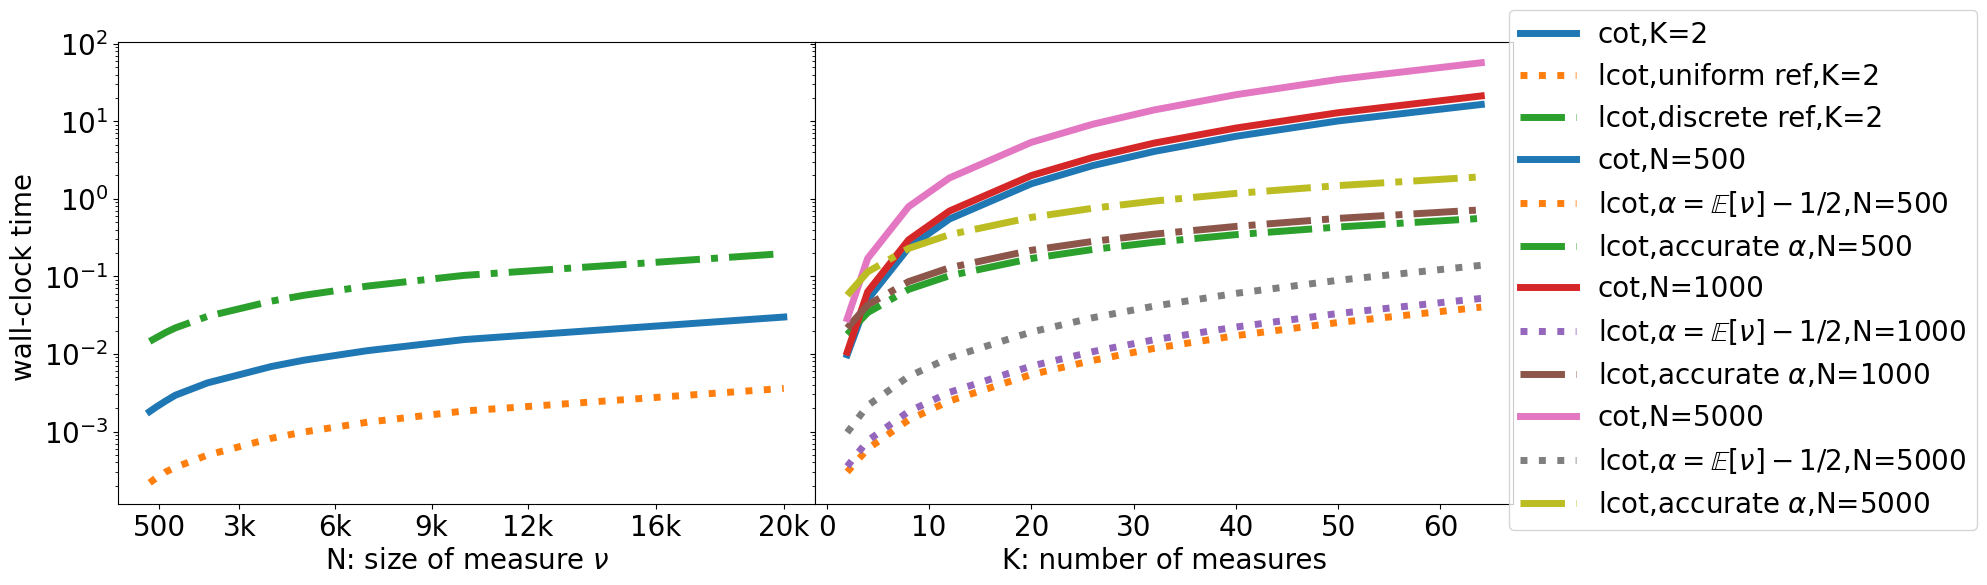

In [50]:
# test the discrete embedding part 3
# Generate some example data

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# First subplot
N_list=np.array([50,1e2,150,2e2,4e2,5e2,7e2,1e3,2e3,4e3,5e3,7e3,1e4,2e4],dtype=np.int64)
linewidth=5
K=2
result=torch.load('result/time_K=%d.pt'%(K))
time_cot=result['cot']
time_lcot_approx=result['lcot_approx']
time_lcot_correct=result['lcot_correct']
time_cot_a=time_cot.mean(1)
time_lcot_approx_a=time_lcot_approx.mean(1)
time_lcot_correct_a=time_lcot_correct.mean(1)
start_index=3
axs[0].semilogy(N_list[start_index:], time_cot_a[start_index:], label='cot,K=2', linestyle='solid',linewidth=linewidth)
axs[0].semilogy(N_list[start_index:], time_lcot_approx_a[start_index:], label=r'lcot,uniform ref,K=2', linestyle='dotted',linewidth=linewidth)
axs[0].semilogy(N_list[start_index:], time_lcot_correct_a[start_index:], label=r'lcot,discrete ref,K=2', linestyle='dashdot',linewidth=linewidth)
N1_list=[500,3000,6000, 9000, 12000,16000,20000]

# axs[0].plot(x_values, y1_values, label='Method 1')

# axs[0].set_xticklabels([f'{x//1000}k' for x in x_values])
# axs[0].tick_params(axis='y', labelsize=30)
# axs[0].set_title('First Subplot')

# Second subplot
result=torch.load('result/time_N,K.pt')
time_cot=result['cot']
time_lcot_approx=result['lcot_approx']
time_lcot_correct=result['lcot_correct']
N_list=[500,1000,5000]
for (N_idx,N) in enumerate(N_list):
    time_cot_N=time_cot[N_idx,:]
    time_lcot_approx_N=time_lcot_approx[N_idx,:]
    time_lcot_correct_N=time_lcot_correct[N_idx,:]
    time_cot_a=time_cot_N.mean(1)
    time_lcot_approx_a=time_lcot_approx_N.mean(1)
    time_lcot_correct_a=time_lcot_correct_N.mean(1)
    # if N<1000:
    #     N_label = '500'
    # else:
    #     N_label = str(int(N/1000))+'k'

    axs[1].semilogy(K_list, time_cot_a, label=r'cot,N=%i'%(N), linestyle='solid',linewidth=linewidth)
    axs[1].semilogy(K_list, time_lcot_approx_a, label=r'lcot,$\alpha=\mathbb{E}[\nu]-1/2$,N=%i'%(N), linestyle='dotted',linewidth=linewidth)
    axs[1].semilogy(K_list, time_lcot_correct_a, label=r'lcot,accurate $\alpha$,N=%i'%(N), linestyle='dashdot',linewidth=linewidth)

xtick_labels = [f"{int(i // 1000)}k" for i in N1_list]
xtick_labels[0]='500'


axs[0].set_xlabel(r'N: size of measure $\nu$',size=20)
axs[0].set_ylabel('wall-clock time ',size=20)
N1_list=[500,3000,6000, 9000, 12000,16000,20000]
xtick_labels = [f"{int(i // 1000)}k" for i in N1_list]
xtick_labels[0]='500'
axs[0].set_xticks(N1_list,labels=xtick_labels,rotation=0, fontsize=20)
axs[1].set_xlabel(r'K: number of measures',size=20)

axs[0].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)



# axs[1].set_xticks(K_list)

# Create a common legend
lines, labels = axs[0].get_legend_handles_labels()

# fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.legend(loc="center left", bbox_to_anchor=(0.89, 0.5), ncol=1,prop={'size':20})
# plt.legend(loc='center left',ncol=1, bbox_to_anchor=(0.9, 0.5),prop={'size': 20})
plt.savefig("result/time.pdf",bbox_inches='tight')
# Show the figure
plt.show()